In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

import util
from util import df_with_selected_features, split_df, split_df_to_x_y, train_model_func

import spacy

In [2]:
nlp = spacy.load('en_core_web_md')
msg = util.read_df('data/messages.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [3]:
# Add length of messages before cleaning
msg['InBoundLength'] = msg['InBound'].apply(len)

# Clean inbound messages and convert them to vector
df = df_with_selected_features(df=msg, col_to_vec='InBound',nlp = nlp, target=['TemplateID'],
                               cat_feats='ConversationType',
                               cat_feats_name=['cart', 'live_text', 'campaigns', 'platform', 'optin_disc',
                                               'optin_conf'],
                               num_feats=['InBoundLength', 'ConversationLength'], 
                                file_path=None, #'out/clean_df.csv'
                               create_vec=False, file_path_vec='out/vectors.csv', save=False)
# put create_vec=True  wnat to create vectors it takes about 40 minutes

print(df.shape)
df.head()

(268880, 309)


,TemplateID,InBoundLength,ConversationLength,0,1,2,3,4,5,6,...,296,297,298,299,cart,live_text,campaigns,platform,optin_disc,optin_conf
0,1150.0,19,9.0,0.329930,-0.273630,-0.181240,-0.511830,0.539350,0.158820,0.006595,...,-0.192330,0.172930,0.126170,0.597920,1,0,0,0,0,0
1,718.0,110,27.0,-0.019328,0.156222,-0.382688,0.198034,-0.093976,0.051917,-0.144020,...,0.126053,-0.102500,-0.048436,0.144246,1,0,0,0,0,0
2,365.0,34,2.0,-0.332885,-0.019312,-0.252119,-0.129854,-0.133659,0.068219,0.043203,...,-0.137383,0.050422,-0.051024,0.220546,0,0,1,0,0,0
3,1150.0,135,3.0,-0.058880,0.021511,-0.126566,-0.093623,-0.030444,0.064870,0.079254,...,-0.115857,0.117376,0.031562,0.105599,0,1,0,0,0,0
4,6650.0,68,2.0,-0.186885,0.218122,-0.277355,-0.147423,-0.063116,-0.031100,0.112962,...,-0.107041,-0.056241,0.069295,0.099407,0,0,1,0,0,0


In [4]:
### Merge some groups
df['TemplateID'] = np.where(df['TemplateID'].isin([321,5617, 718]), 321, df['TemplateID'])
df['TemplateID'] = np.where(df['TemplateID'].isin([6651, 5244]), 5244, df['TemplateID'])

## Split Data

In [7]:
# Split Data and remove duplicate rows
train, test = split_df(df, test_size=0.2, random_state=42, drop_duplicate_train=True)

X_train, y_train = split_df_to_x_y(train, target='TemplateID', specify_features=None)
X_test, y_test = split_df_to_x_y(test, target='TemplateID', specify_features=None)

---
# Train models
### Random Forests

best parameters:  {'max_depth': 15, 'n_estimators': 100}
----------------------------------------------------------------------
best_model:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Confusion Matrix:



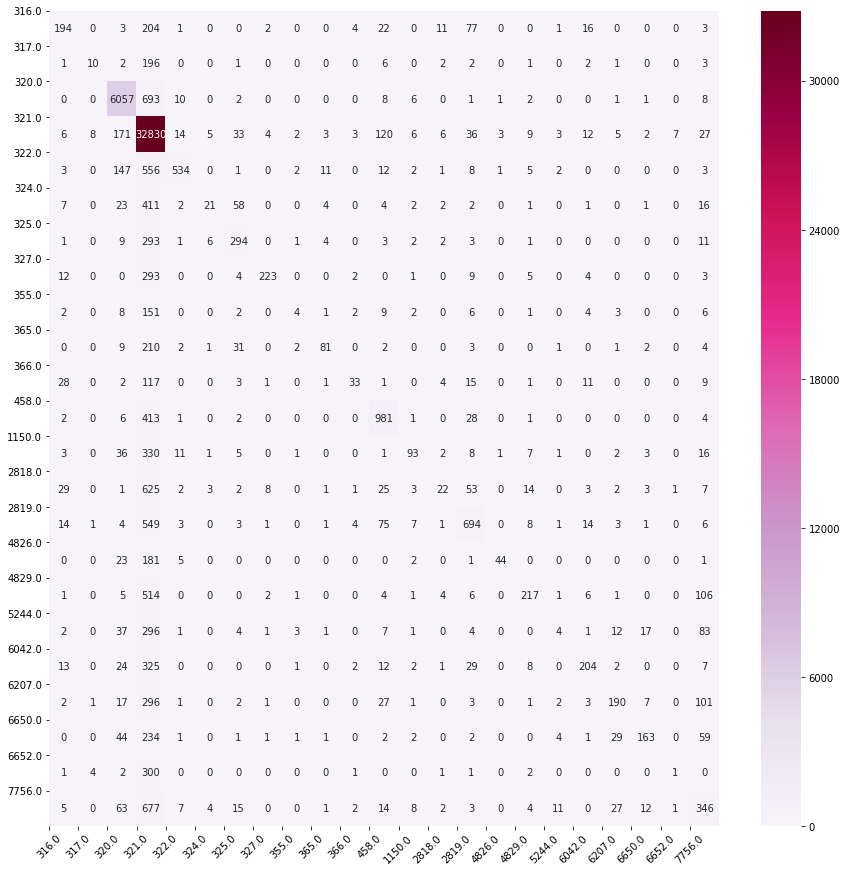

-------------------------
              precision    recall  f1-score   support

       316.0       0.60      0.36      0.45       538
       317.0       0.42      0.04      0.08       227
       320.0       0.90      0.89      0.90      6790
       321.0       0.81      0.99      0.89     33315
       322.0       0.90      0.41      0.57      1288
       324.0       0.51      0.04      0.07       555
       325.0       0.63      0.47      0.54       631
       327.0       0.91      0.40      0.56       556
       355.0       0.22      0.02      0.04       201
       365.0       0.74      0.23      0.35       349
       366.0       0.61      0.15      0.24       226
       458.0       0.73      0.68      0.71      1439
      1150.0       0.65      0.18      0.28       521
      2818.0       0.36      0.03      0.05       805
      2819.0       0.70      0.50      0.58      1390
      4826.0       0.88      0.17      0.29       257
      4829.0       0.75      0.25      0.38       869
 

In [11]:
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=42)
param_grid_rf = [{'n_estimators': [100], 'max_depth': [12, 15]}]

rf_model = train_model_func(X=X_train, y=np.ravel(y_train),
                            estimator=rf_clf, param_grid=param_grid_rf, cv=5, scoring="neg_log_loss")

rf_metrics, rf_report = util.metrics(rf_model, X_test, y_test)

In [14]:
util.save_model("models/random_forest.pkl", rf_model)

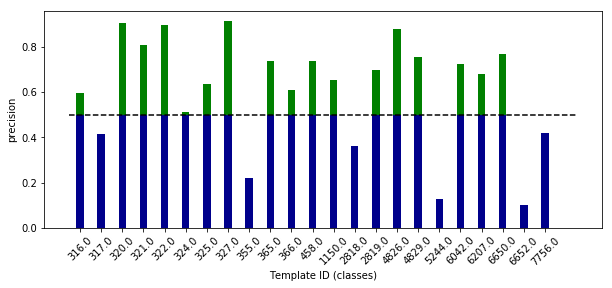

In [15]:
values = rf_report['precision'][:-3]
x = range(len(values))
threshold =0.5
above_threshold = np.maximum(values - threshold, 0)
below_threshold = np.minimum(values, threshold)

plt.figure(figsize = (10, 4))
plt.bar(x, below_threshold, 0.35, color="darkblue")
plt.bar(x, above_threshold, 0.35, color="green",
        bottom=below_threshold)

# horizontal line indicating the threshold
plt.plot([-.5, 23.5], [threshold, threshold], "k--")

plt.xticks(ticks= np.arange(len(rf_report.index[:-3])) ,labels = rf_report.index[:-3], rotation=45)
plt.ylabel("precision")
plt.xlabel("Template ID (classes)")
plt.show()